In [1]:
from used_packages import *
from data import import_data, extract_roi_data, train_test, dataset_loader
from models import svm_model, simple_nn
from RPCA import RPCA_image_decomp
from utils import plot_image, map_roi, tensor, load_nn, eval_nn, conf, set_seed

## Import Hyperspectral Images (HSI)

In [2]:
# import HSI images anc convert to hdr
casi_hdr = import_data('data/2013_IEEE_GRSS_DF_Contest_CASI.tif', hdr_path='data/2013_IEEE_GRSS_DF_Contest_CASI.hdr')
# reshape tensor; move image index to the front - (im index, height, width)
casi_hdr = casi_hdr.transpose((2, 0, 1))

'spectral' package (which is used to extract info from .hdr file and convert images to hdr) seems to have removed the last 6 columns and spliced them with the first column of the image. Odd behaviour, had to adjust that below.


In [3]:
# adjusting the HDR images
cols_to_shift = casi_hdr[:, :, 0:6]
temp_const = np.zeros_like(cols_to_shift)
temp_const[:,4:-1,:] = cols_to_shift[:,5:,:]
casi_hdr_adjusted = np.concatenate((casi_hdr[:,:,6:], temp_const), axis=2)

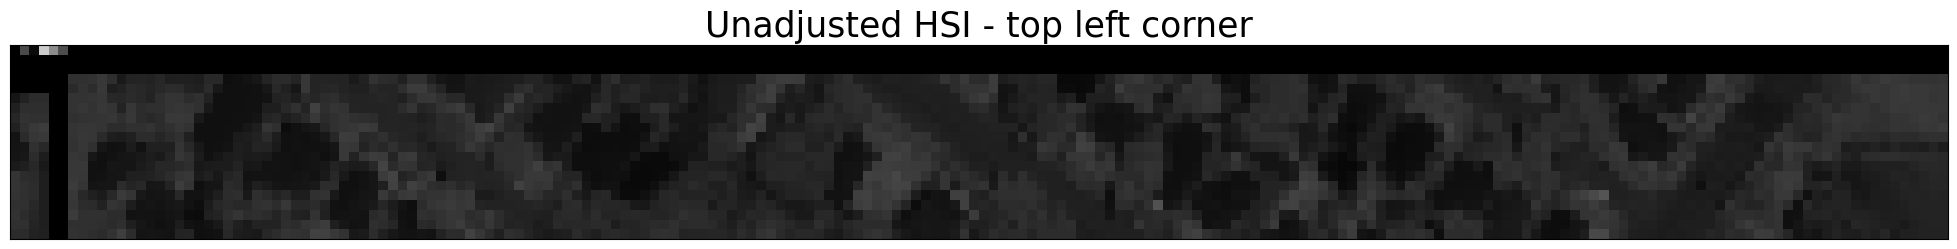

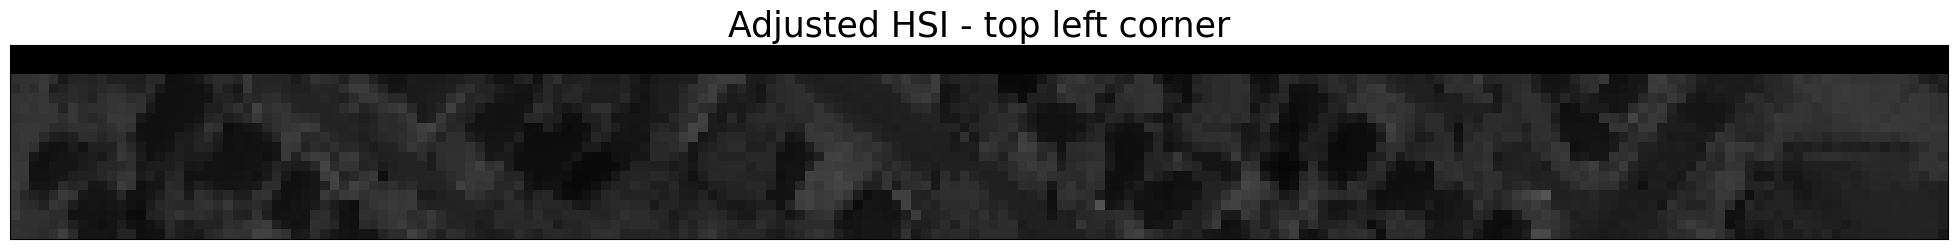

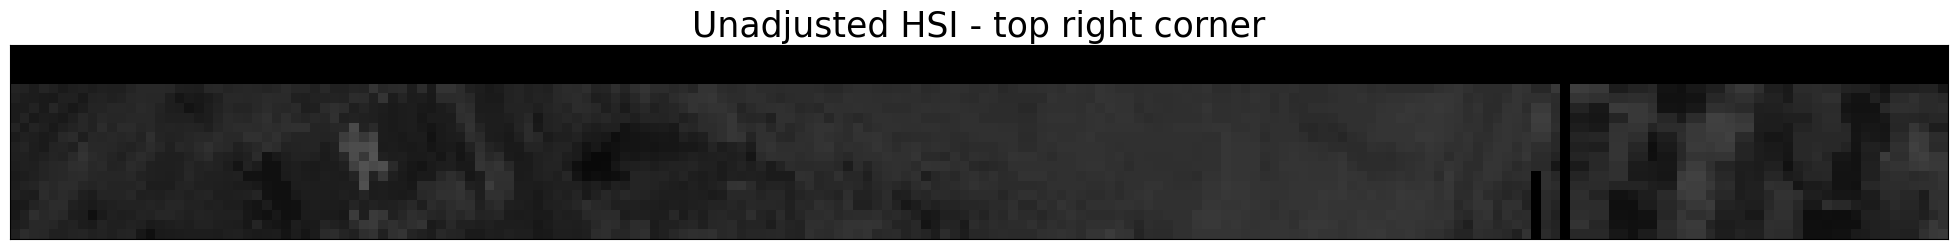

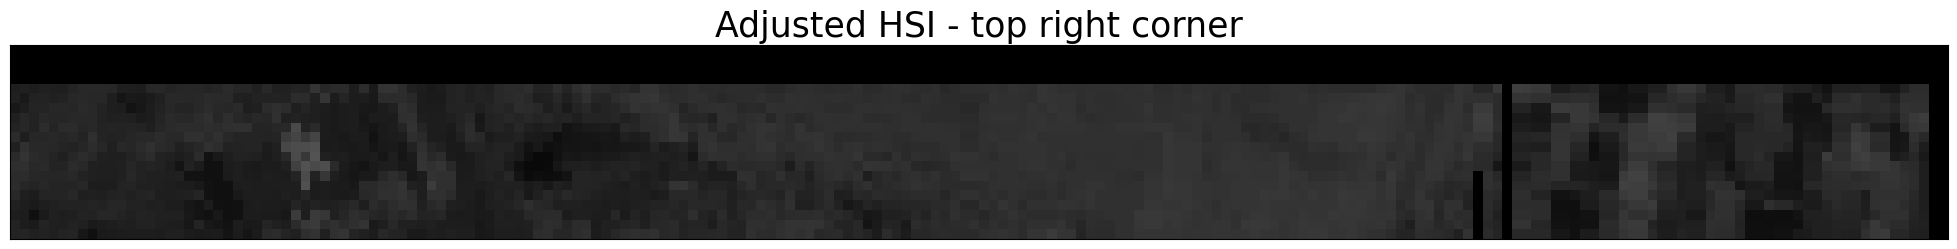

In [4]:
plot_image(casi_hdr[70,:20,:200], title='Unadjusted HSI - top left corner', fig_size=(25,7), fs=25, vmin=casi_hdr.min(), vmax=casi_hdr.max())
plot_image(casi_hdr_adjusted[70,:20,:200], title='Adjusted HSI - top left corner', fig_size=(25,7), fs=25, vmin=casi_hdr.min(), vmax=casi_hdr.max())

plot_image(casi_hdr[70,:20,-200:], title='Unadjusted HSI - top right corner', fig_size=(25,7), fs=25, vmin=casi_hdr.min(), vmax=casi_hdr.max())
plot_image(casi_hdr_adjusted[70,:20,-200:], title='Adjusted HSI - top right corner', fig_size=(25,7), fs=25, vmin=casi_hdr.min(), vmax=casi_hdr.max())

## Import the LiDAR Image

In [5]:
lidar = import_data('data/2013_IEEE_GRSS_DF_Contest_LiDAR.tif', hdr_path=None)

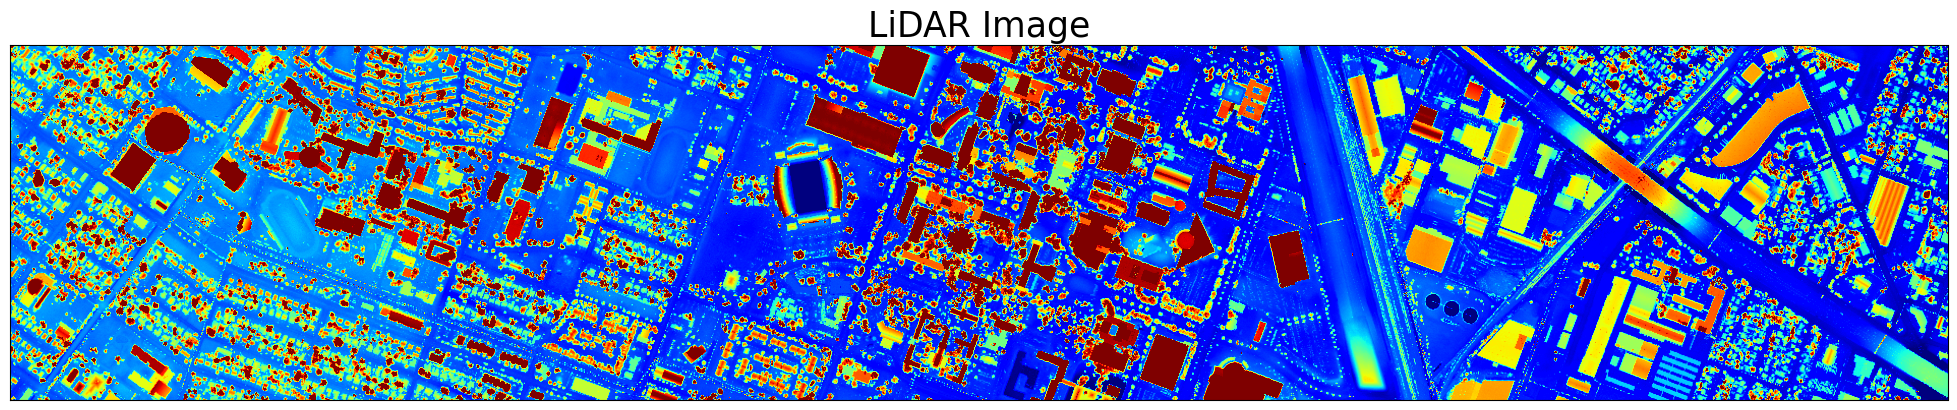

In [6]:
plot_image(lidar[0,:,:], title='LiDAR Image', fig_size=(25,7), cmap='jet', vmin=10, vmax=23)

## Load and Extract Class Indices

In [7]:
# load class rgb color information
from scipy.io import loadmat
avar = loadmat('data/AVIRIS_colormap.mat')
avaris = avar['mycolormap']

In [8]:
# Extract train and test indices, rgb color, and class information
roi_tr = extract_roi_data('data/2013_IEEE_GRSS_DF_Contest_Samples_TR.txt')
roi_ts = extract_roi_data('data/2013_IEEE_GRSS_DF_Contest_Samples_VA - cleaned.txt')

# separate train and test indices
cl_tr = []
cl_ts = []
for i in range(len(roi_tr)):
    cl = pd.DataFrame(roi_tr[i]['points']).loc[:, ['Y', 'X']]
    cl_tr.append(cl)
for i in range(len(roi_ts)):
    cl = pd.DataFrame(roi_ts[i]['points']).loc[:, ['Y', 'X']]
    cl_ts.append(cl)

In [9]:
# map classes to black background and to an HSI
labels_tr, labels_ts, rgb_image_full, rgb_image_tr, rgb_image_ts, rgb_image_full =(
    map_roi(casi_hdr_adjusted[70,:,:],
            tr_ind=cl_tr,
            ts_ind=cl_ts,
            color_map=avaris,
            roi_path='data/2013_IEEE_GRSS_DF_Contest_Samples_TR.txt'))

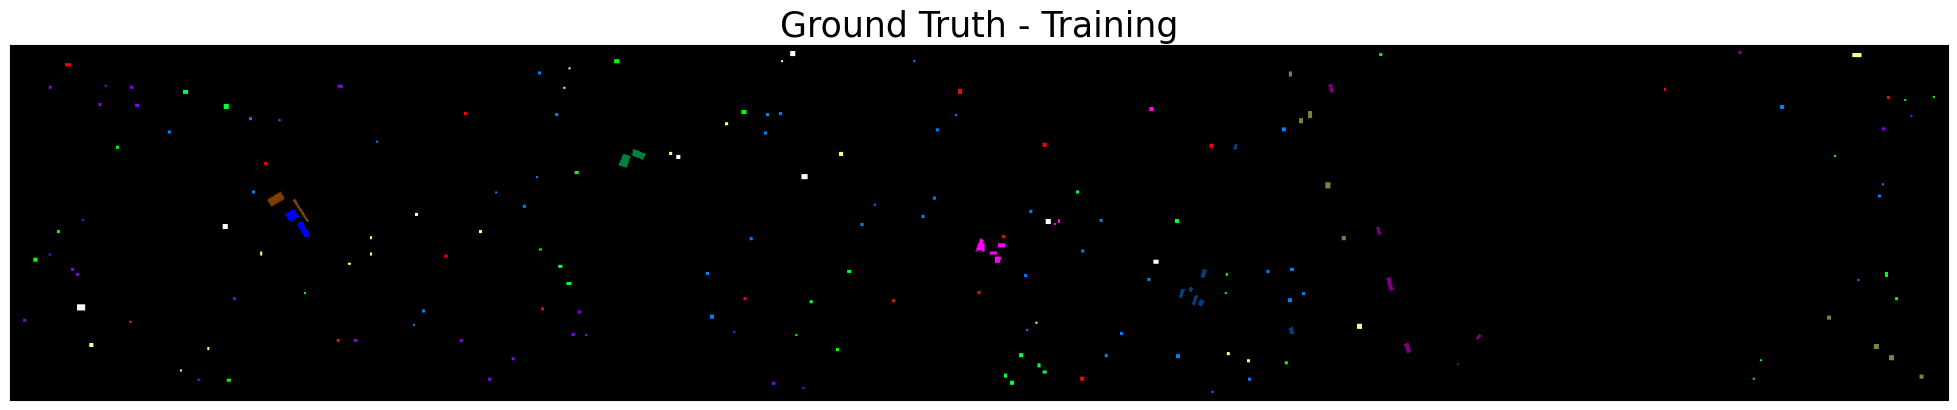

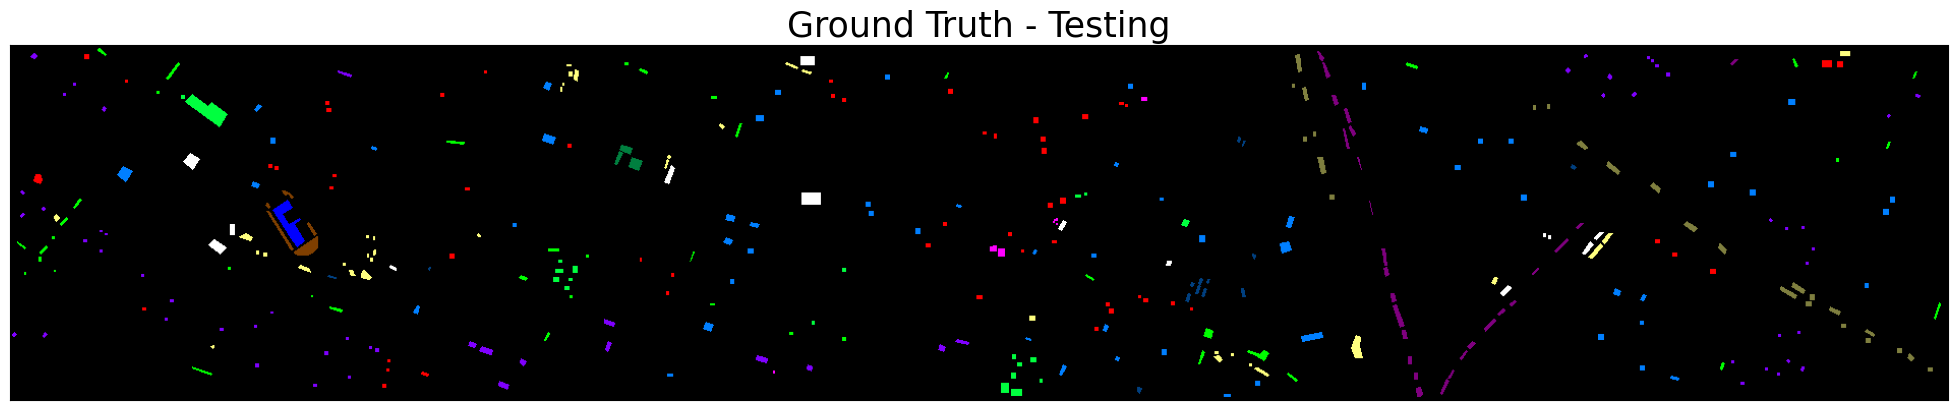

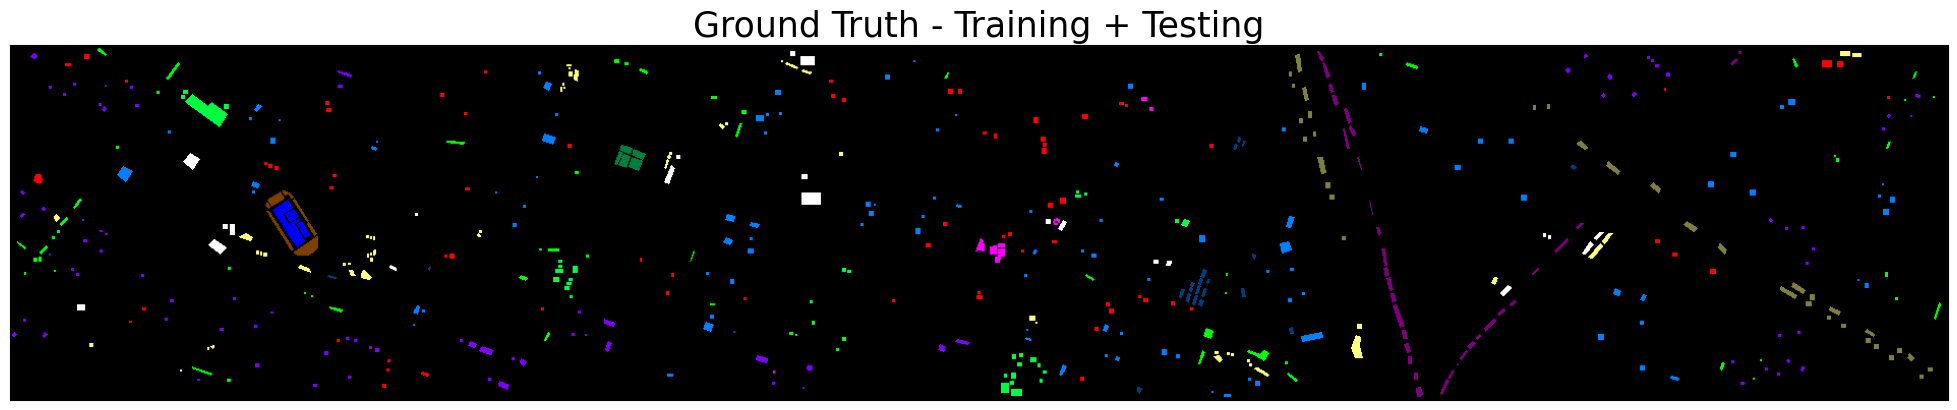

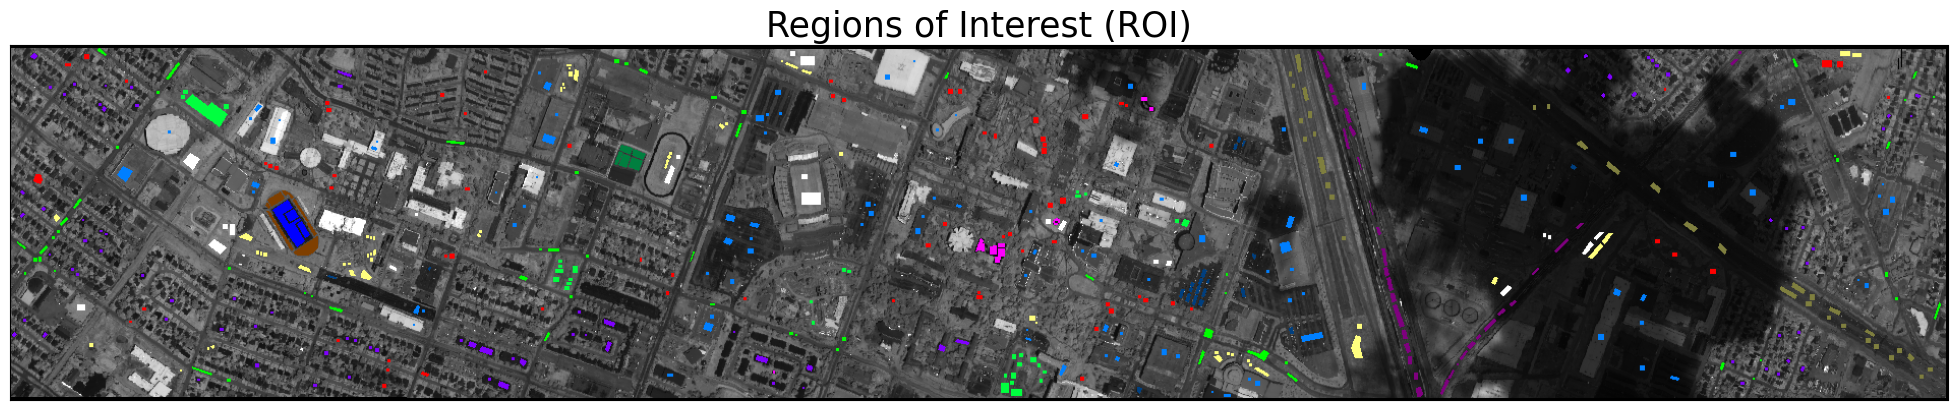

In [10]:
# Plot mapped classes

plot_image(rgb_image_tr, title='Ground Truth - Training', fig_size=(25,7), save=False)
plot_image(rgb_image_ts, title='Ground Truth - Testing', fig_size=(25,7), save=False)

rgb_both = np.clip((rgb_image_tr + rgb_image_ts), 0,1)
plot_image(rgb_both, title='Ground Truth - Training + Testing', fig_size=(25,7), save=False)

rgb_lidar_clip = np.clip(rgb_image_full, 0,1)
plot_image(rgb_lidar_clip, title='Regions of Interest (ROI)', fig_size=(25,7), save=False)

In [11]:
# Vectorize the HSI images and stack in columns
casi_unfold = casi_hdr_adjusted.reshape(144,-1)

# Denoise the Images - Robust PCA

$M = L + S$

M: matrix with sparse outliers (noise)

L: smooth compnent

S: sparse component

A method to detect and remove sparse noise in images. Sparsity of the noise is crucial, otherwise, the method will extract sparse feature information. Level of extraction can be controlled by fine-tuning $\lambda$ and $\rho$ hyperparameters.

In [ ]:
L, S = RPCA_image_decomp(casi_unfold[:,:], lam=0.0022, rho=1.5, tol=1e-6, max_iter=100, verbose=True)

In [ ]:
# Plot all denoised images
'''for i in range(L.shape[0]):
    plot_image(L.cpu().numpy().reshape(-1, 349, 1905)[i,:,:], title=f'{i}th HSI - Denoised', fontsize=20, fig_size=(25,7))
'''

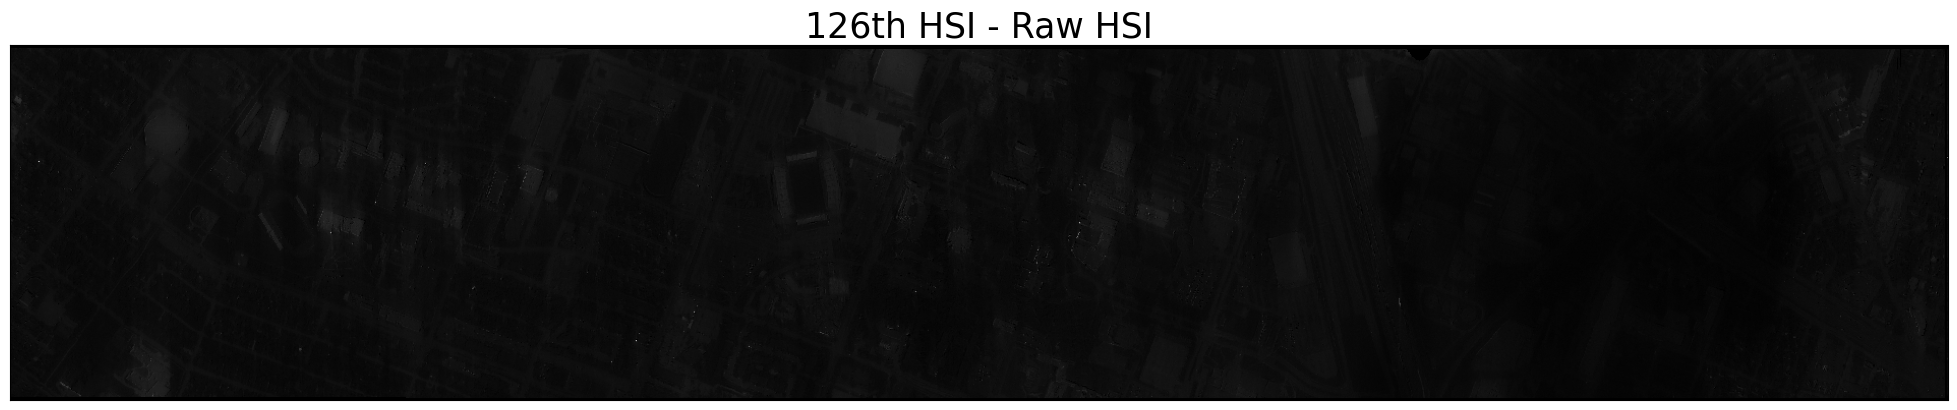

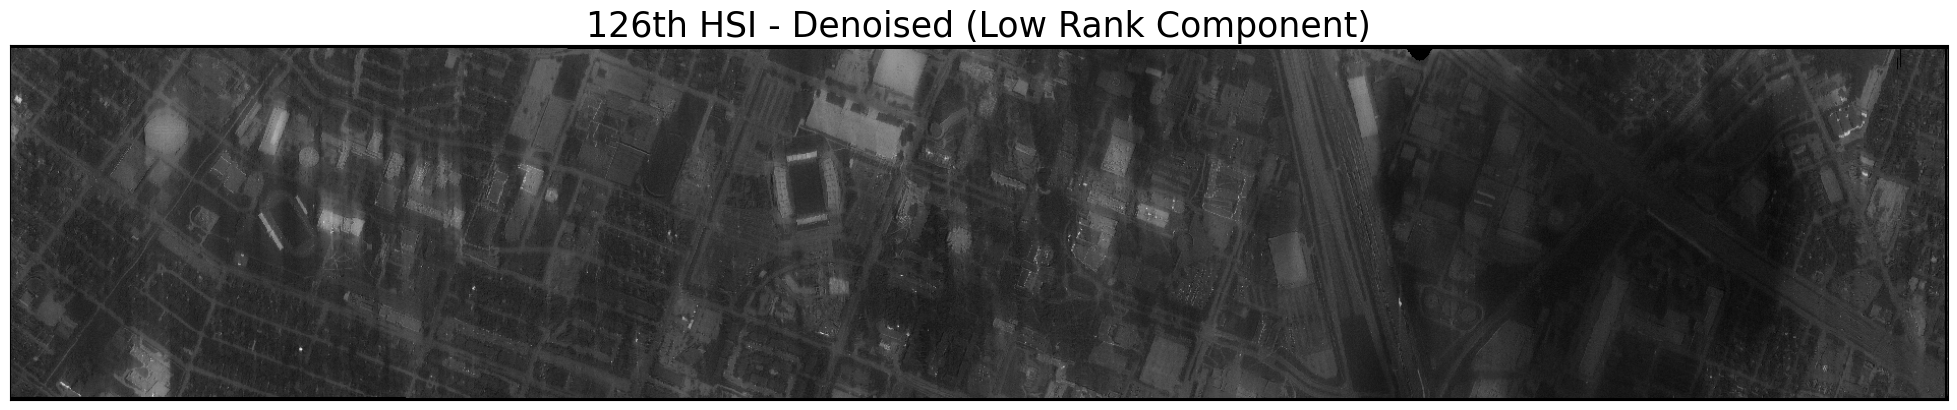

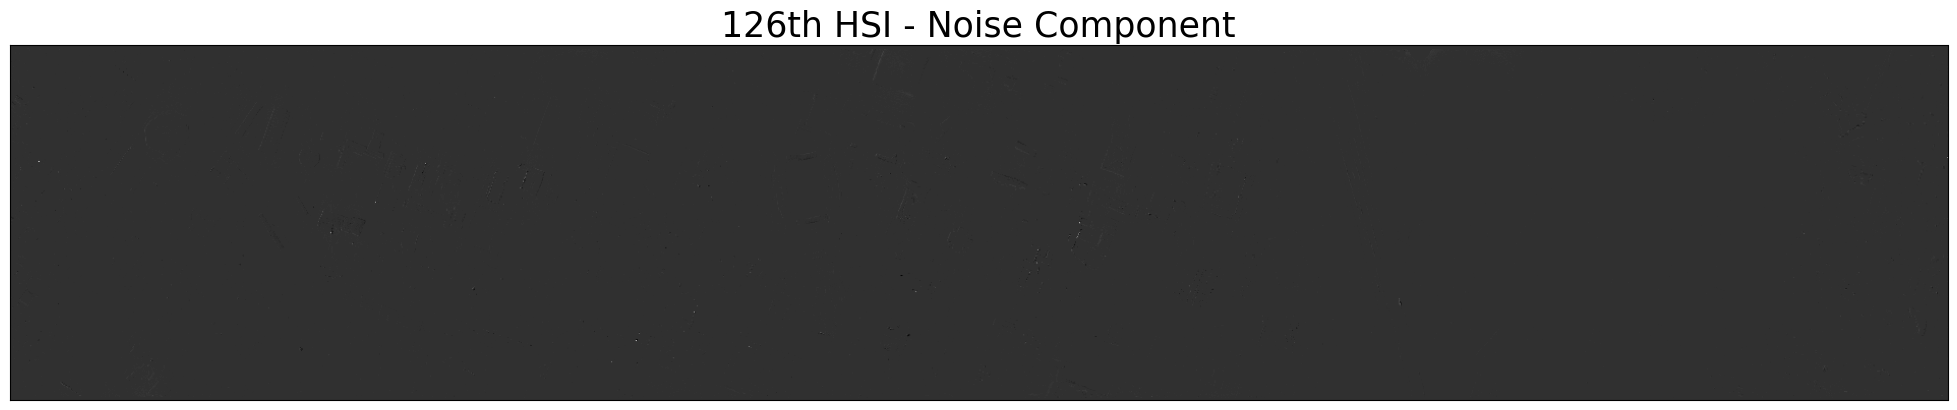

In [20]:
plot_image(casi_hdr_adjusted[126,:,:], title=f'{126}th HSI - Raw HSI', fs=25, fig_size=(25,7), save=False)
plot_image(L.cpu().numpy().reshape(-1, 349, 1905)[126,:,:], title=f'{126}th HSI - Denoised (Low Rank Component)', fs=25, fig_size=(25,7), save=False)
plot_image(S.cpu().numpy().reshape(-1, 349, 1905)[126,:,:], title=f'{126}th HSI - Noise Component', fs=25, fig_size=(25,7), save=False)

## Vectorize images

2D matrices to train the models

In [15]:
# lidar image
lidar_unfold = tensor(lidar.reshape(1,-1))
# denoised (low rank) HSI combined with lidar
L_w_lidar = torch.concat((L, lidar_unfold), dim=0)
# raw HSI combined with lidar
casi_w_lidar = torch.concat((tensor(casi_unfold), lidar_unfold), dim=0)

# Simple Neural Network: saved best models
## Load best NN model - Low rank HSI:

In [21]:
# load the data
X_train, y_train, X_test, y_test = train_test(L, labels_tr, labels_ts)
train_loader, test_loader = dataset_loader(X_train, y_train, X_test, y_test, batch_size=64)
path1 = 'saved models/best models/best_model - NN_l acc 0.7800.pth'
# load the model
model_l = load_nn(X_train.shape[1], model_path=path1)

# evaluate model
acc_nn_l, cm_l, y_pred_nn_l = eval_nn(test_loader, model_l)
acc_class_nn_l = conf(cm_l, display_cm=False)


Overall Accuracy 78.00%
Per-class Accuracy (%)
=============================         0
1   82.72
2   82.89
3   99.41
4   83.90
5   97.16
6   95.10
7   75.75
8   51.28
9   76.68
10  52.03
11  78.37
12  72.72
13  76.49
14  99.60
15  97.46



## Load best NN model - Raw HSI:

In [17]:
# load the data
X_train, y_train, X_test, y_test = train_test(casi_unfold, labels_tr, labels_ts)
train_loader, test_loader = dataset_loader(X_train, y_train, X_test, y_test, batch_size=64)
path2 = 'saved models/best models/best_model - NN_r acc 0.7753 .pth'
# load the model
model_r = load_nn(X_train.shape[1], model_path=path2)

# evaluate model
acc_nn_r, cm_r, y_pred_nn_r = eval_nn(test_loader, model_r)
acc_class_nn_r = conf(cm_r, display_cm=False)



Overall Accuracy 77.53%
Per-class Accuracy (%)
=============================         0
1   82.43
2   79.42
3   99.21
4   88.07
5   96.40
6   95.10
7   83.49
8   59.83
9   61.85
10  45.08
11  69.26
12  83.57
13  72.28
14  96.76
15  98.52



## Load best NN model - Low rank HSI with LiDAR:

In [22]:
# load the data
X_train, y_train, X_test, y_test = train_test(L_w_lidar, labels_tr, labels_ts)

train_loader, test_loader = dataset_loader(X_train, y_train, X_test, y_test, batch_size=64)
path3 = 'saved models/best models/best_model - NN_lwl acc 0.8293.pth'
# load the model
model_lwl = load_nn(X_train.shape[1], model_path=path3)

# evaluate model
acc_nn_lwl, cm_lwl, y_pred_nn_lwl = eval_nn(test_loader, model_lwl)
acc_class_nn_lwl = conf(cm_lwl, display_cm=False)


Overall Accuracy 82.93%
Per-class Accuracy (%)
=============================         0
1   80.72
2   96.99
3   99.21
4   90.62
5   97.16
6   95.10
7   84.61
8   73.31
9   80.45
10  41.51
11  87.19
12  80.60
13  78.60
14  87.85
15  95.77



## Load best NN model - Raw HSI with LiDAR:

In [23]:
# load the data
X_train, y_train, X_test, y_test = train_test(casi_w_lidar, labels_tr, labels_ts)
train_loader, test_loader = dataset_loader(X_train, y_train, X_test, y_test, batch_size=64)
path4 = 'saved models/best models/best_model - NN_rwl acc 0.8150.pth'
# load the model
model_rwl = load_nn(X_train.shape[1], model_path=path4)

# evaluate model
acc_nn_rwl, cm_rwl, y_pred_nn_rwl = eval_nn(test_loader, model_rwl)
acc_class_nn_rwl = conf(cm_rwl, display_cm=False)



Overall Accuracy 81.50%
Per-class Accuracy (%)
=============================         0
1   80.91
2   83.93
3   96.24
4   89.11
5   99.53
6   83.92
7   83.77
8   68.85
9   78.66
10  36.68
11  93.74
12  83.29
13  69.82
14  97.17
15  98.94



# SVM:
## Best SVM model - Low rank HSI with LiDAR:

In [24]:
X_train, y_train, X_test, y_test = train_test(L_w_lidar, labels_tr, labels_ts)
'''C = np.linspace(0.0001, 10, 5)
bias = range(40)
acc_svm_lwl, C_svm_lwl, bias_svm_lwl, conf_svm_lwl, y_svm_lwl = svm_model(X_train, y_train, X_test, y_test,
                                                  C, kernel='poly', degree=3, bias=bias, verbose=True)'''

acc_svm_lwl, C_svm_lwl, bias_svm_lwl, conf_svm_lwl, y_svm_lwl = svm_model(X_train, y_train, X_test, y_test,
                                                                          [2.5001], kernel='poly', degree=3, bias=[28], verbose=True)

Model 1/1 - C: 2.5001, bias: 28, accuracy: 79.54%
Best Model - accuracy: 79.54%, C: 2.5001, bias: 28


In [25]:
# best SVM model
acc_class_svm_lwl = conf(conf_svm_lwl, display_cm=False)


Overall Accuracy 79.54%
Per-class Accuracy (%)
=============================         0
1   78.82
2   84.68
3   99.41
4   89.30
5   98.58
6   95.80
7   80.32
8   55.46
9   82.06
10  64.67
11  70.40
12  64.46
13  86.32
14  98.38
15  97.46



## Best SVM model - Low rank HSI:

In [26]:
X_train, y_train, X_test, y_test = train_test(L, labels_tr, labels_ts)
'''C = np.linspace(0.0001, 10, 5)
bias = range(40)
acc_svm_l, C_svm_l, bias_svm_l, conf_svm_l, y_svm_l = svm_model(X_train, y_train, X_test, y_test,
                                                                C, kernel='poly', degree=3, bias=bias, verbose=True)'''

acc_svm_l, C_svm_l, bias_svm_l, conf_svm_l, y_svm_l = svm_model(X_train, y_train, X_test, y_test,
                                                                [2.5001], kernel='poly', degree=3, bias=[24], verbose=True)

Model 1/1 - C: 2.5001, bias: 24, accuracy: 77.28%
Best Model - accuracy: 77.28%, C: 2.5001, bias: 24


In [27]:
# best SVM model
acc_class_svm_l = conf(conf_svm_l, display_cm=False)


Overall Accuracy 77.28%
Per-class Accuracy (%)
=============================          0
1    80.53
2    84.59
3    99.41
4    82.39
5    98.77
6    97.90
7    74.25
8    52.33
9    71.58
10   59.85
11   69.45
12   69.16
13   84.21
14  100.00
15   97.04



## Best SVM model - Raw HSI:

In [28]:
X_train, y_train, X_test, y_test = train_test(casi_unfold, labels_tr, labels_ts)
'''C = np.linspace(0.0001, 10, 5)
bias = range(40)
acc_svm_r, C_svm_r, bias_svm_r, conf_svm_r, y_svm_r = svm_model(X_train, y_train, X_test, y_test,
                                                                C, kernel='poly', degree=3, bias=bias, verbose=True)'''

acc_svm_r, C_svm_r, bias_svm_r, conf_svm_r, y_svm_r = svm_model(X_train, y_train, X_test, y_test,
                                                                [2.5001], kernel='poly', degree=3, bias=[21], verbose=True)

Model 1/1 - C: 2.5001, bias: 21, accuracy: 77.06%
Best Model - accuracy: 77.06%, C: 2.5001, bias: 21


In [29]:
# best SVM model
acc_class_svm_r = conf(conf_svm_r, display_cm=False)


Overall Accuracy 77.06%
Per-class Accuracy (%)
=============================         0
1   80.53
2   84.49
3   99.41
4   81.82
5   98.77
6   98.60
7   75.28
8   52.52
9   71.39
10  59.65
11  67.74
12  68.97
13  81.40
14  98.38
15  97.46



## Best SVM model - Raw HSI with LiDAR:

In [30]:
X_train, y_train, X_test, y_test = train_test(casi_w_lidar, labels_tr, labels_ts)
'''C = np.linspace(0.0001, 10, 5)
bias = range(40)
acc_svm_rwl, C_svm_rwl, bias_svm_rwl, conf_svm_rwl, y_svm_rwl = svm_model(X_train, y_train, X_test, y_test,
                                                                          C, kernel='poly', degree=3, bias=bias, verbose=True)'''

acc_svm_rwl, C_svm_rwl, bias_svm_rwl, conf_svm_rwl, y_svm_rwl = svm_model(X_train, y_train, X_test, y_test,
                                                                          [2.5001], kernel='poly', degree=3, bias=[24], verbose=True)

Model 1/1 - C: 2.5001, bias: 24, accuracy: 79.81%
Best Model - accuracy: 79.81%, C: 2.5001, bias: 24


In [31]:
# best SVM model
acc_class_svm_rwl = conf(conf_svm_rwl, display_cm=False)


Overall Accuracy 79.81%
Per-class Accuracy (%)
=============================         0
1   78.92
2   84.68
3   99.41
4   89.68
5   98.39
6   96.50
7   80.60
8   54.80
9   83.29
10  64.86
11  71.44
12  65.13
13  84.56
14  98.38
15  98.52



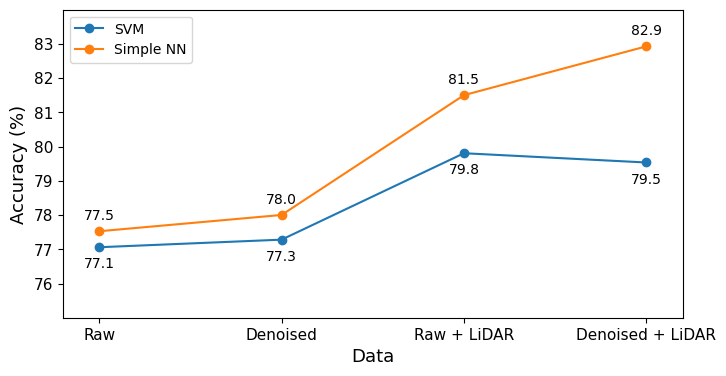

In [66]:
acc_svm_all_models = [acc_svm_r, acc_svm_l, acc_svm_rwl, acc_svm_lwl]
acc_nn_all_models = [acc_nn_r, acc_nn_l, acc_nn_rwl, acc_nn_lwl]

plt.figure(figsize=(8,4))
plt.plot(acc_svm_all_models, marker='o')
plt.plot(acc_nn_all_models, marker='o')

for i, (svm_acc, nn_acc) in enumerate(zip(acc_svm_all_models, acc_nn_all_models)):
    plt.annotate(f'{svm_acc:.1f}', (i, svm_acc), textcoords="offset points", xytext=(-0,-15), ha='center')
    plt.annotate(f'{nn_acc:.1f}', (i, nn_acc), textcoords="offset points", xytext=(-0,8), ha='center')

plt.legend(['SVM', 'Simple NN'], loc='upper left')
plt.xticks(range(4), ['Raw', 'Denoised', 'Raw + LiDAR', 'Denoised + LiDAR'], fontsize=11)
plt.xlabel('Data', fontsize=13)
plt.ylabel('Accuracy (%)', fontsize=13)
plt.yticks(range(76,84), fontsize=11)
plt.ylim(75, 84)
plt.xlim(-0.2, 3.2)
plt.grid(False)
plt.show()

# Prediction using the entire dataset and map the results
Accuracy is higher because training data was included

## Simple NN

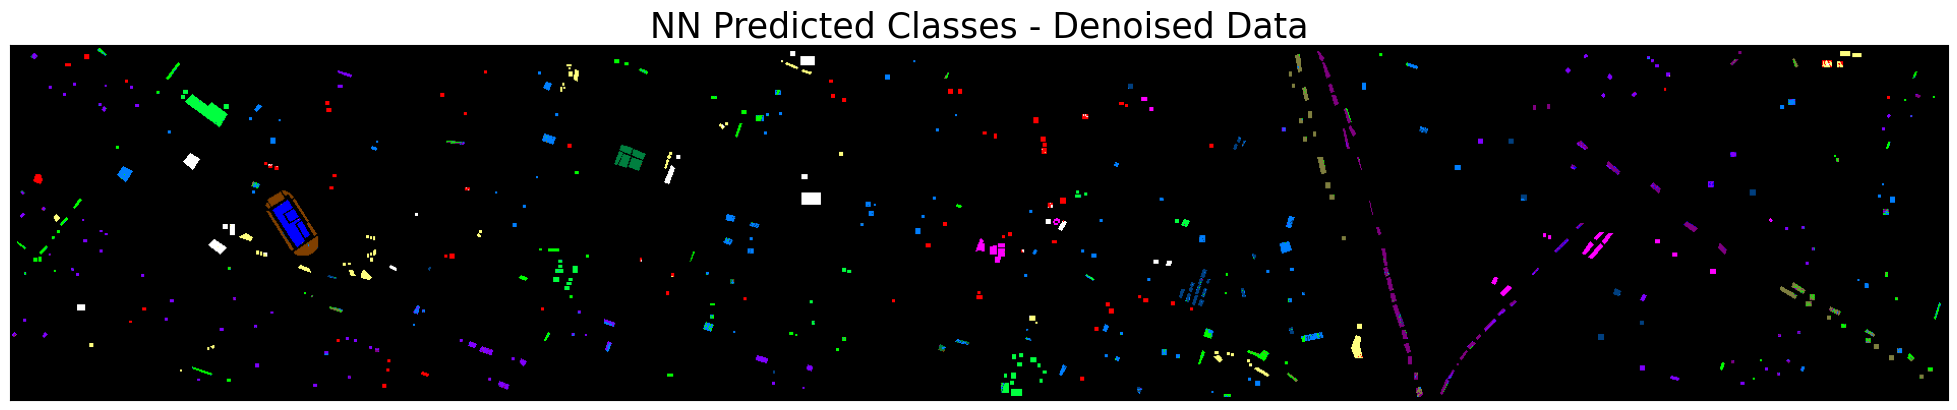

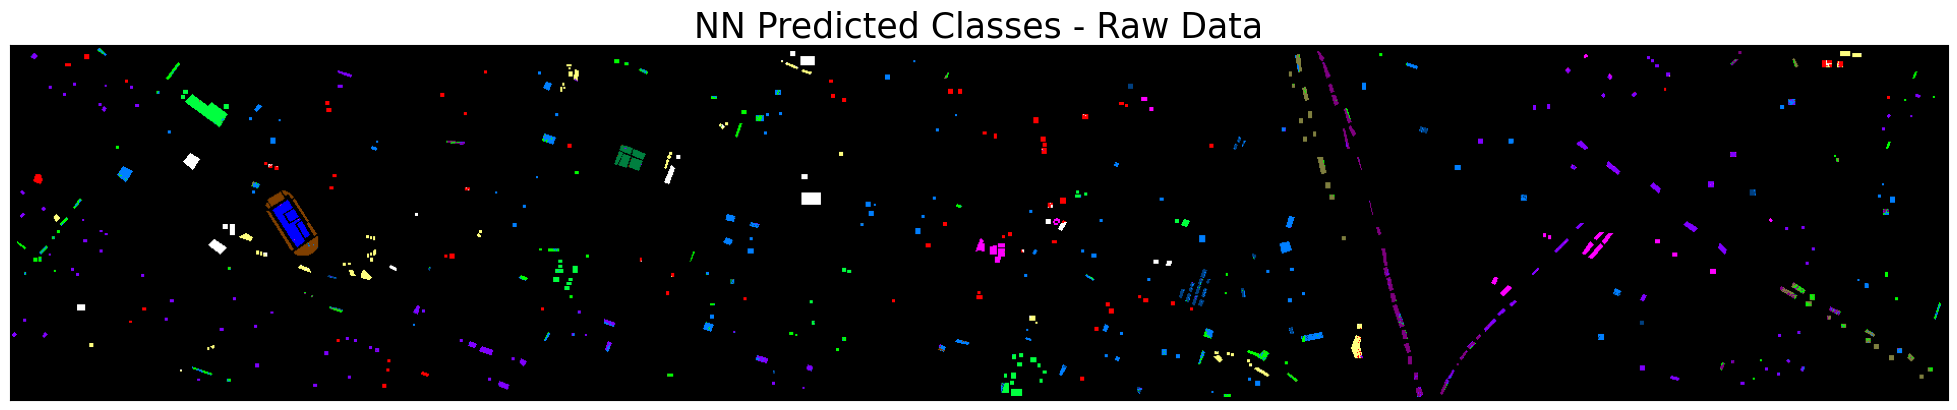

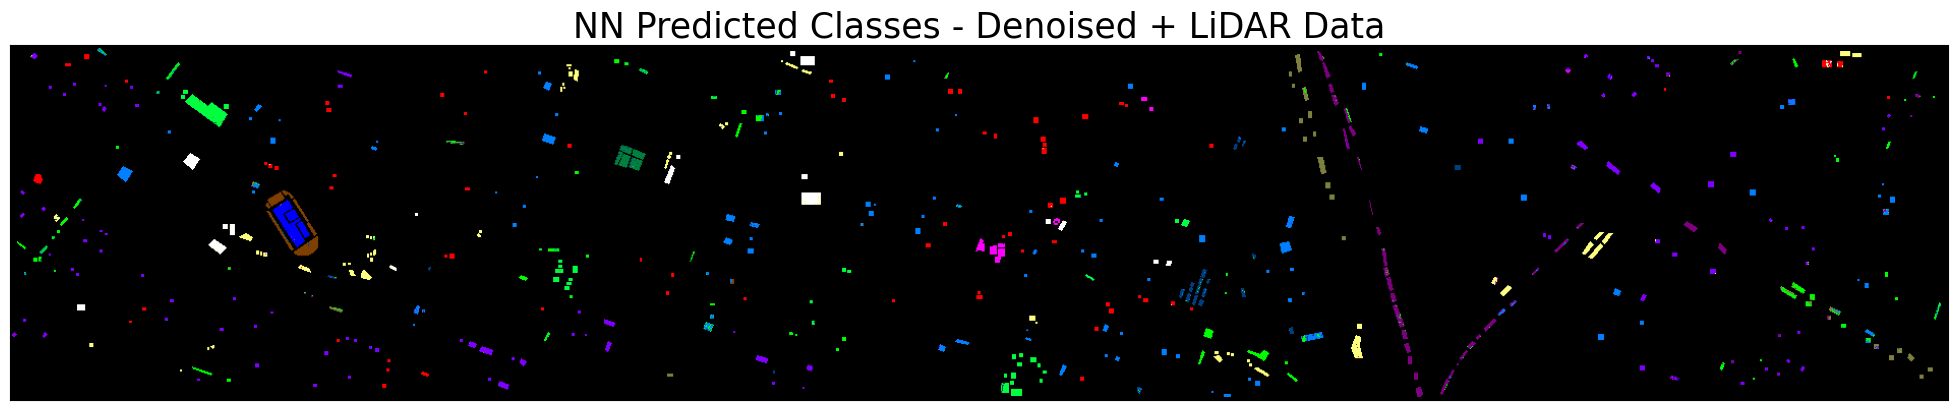

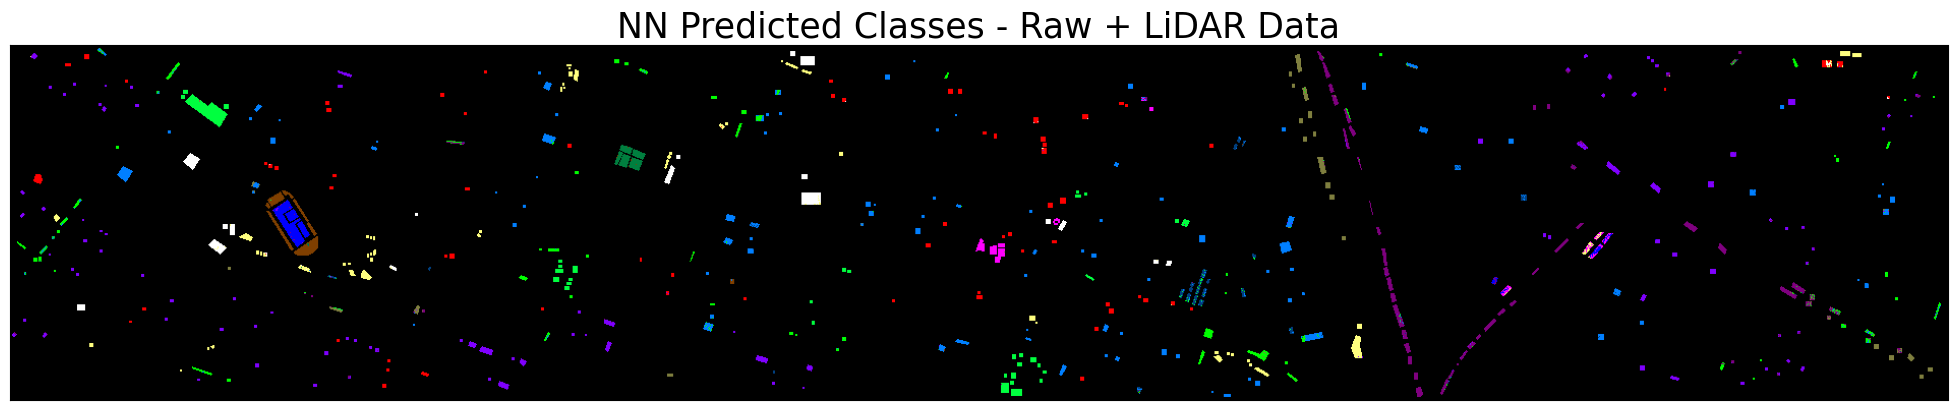

In [75]:
dict_nn = {'Denoised': L,  # Low rank (denoised) data
           'Raw': casi_unfold,  # Raw data
           'Denoised + LiDAR': L_w_lidar,  # Low rank concatenated with Lidar
           'Raw + LiDAR': casi_w_lidar  # raw concatenated with Lidar
           }

paths = [path1, path2, path3, path4]

label_ind_tr = np.argwhere(labels_tr > 0)
label_ind_ts = np.argwhere(labels_ts > 0)
labels_all = np.concatenate((label_ind_tr, label_ind_ts), axis=0)
i = 0
for key, value in dict_nn.items():
    X_train, y_train, X_test, y_test = train_test(value, labels_tr, labels_ts)
    X = np.concatenate((X_train, X_test), axis=0)
    y = np.concatenate((y_train, y_test), axis=0)
    
    train_loader, test_loader = dataset_loader(X_train, y_train, X, y, batch_size=64)
    model_all = load_nn(X_train.shape[1], model_path=paths[i])
    
    # evaluate model
    _, _, y_pred_nn_all = eval_nn(test_loader, model_all)
    test_rgb = np.stack(np.zeros_like((lidar[0, :, :],) * 3), axis=2)
    for row in range(labels_all.shape[0]):
        test_rgb[labels_all[row, 0], labels_all[row, 1]] = avaris[int(y_pred_nn_all[row])].tolist()
    plot_image(test_rgb, title=f'NN Predicted Classes - {key} Data', fig_size=(25, 7), save=False)
    i += 1


## SVM

Best Model - accuracy: 81.40%, C: 2.5001, bias: 24


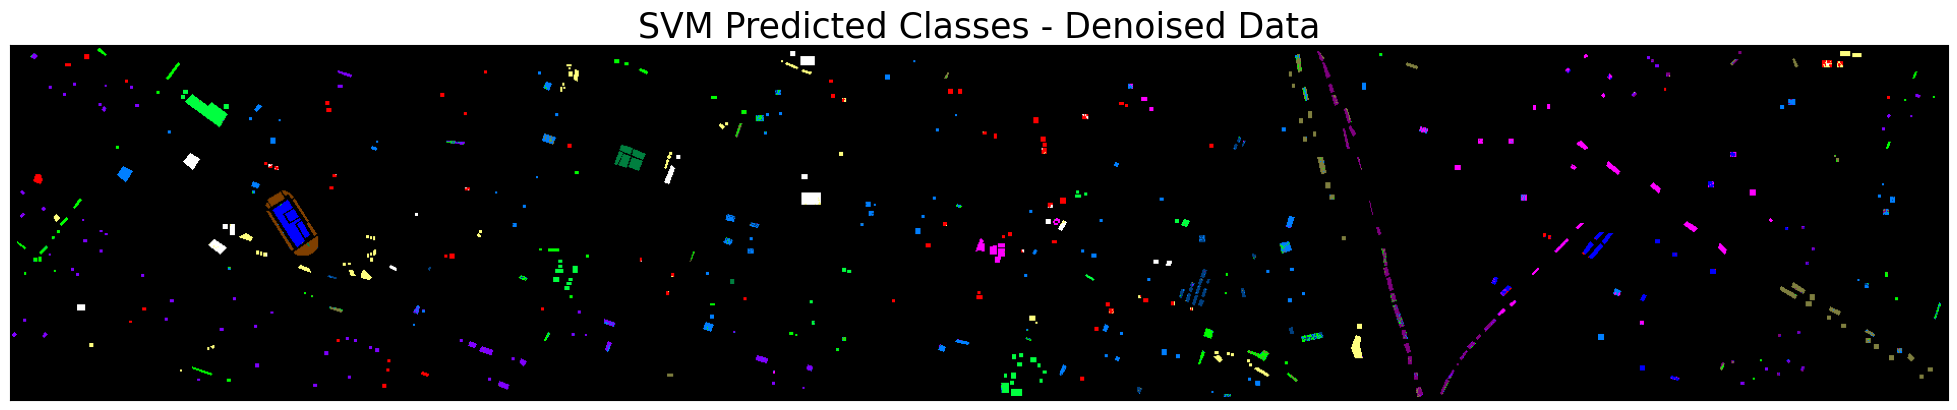

Best Model - accuracy: 81.20%, C: 2.5001, bias: 21


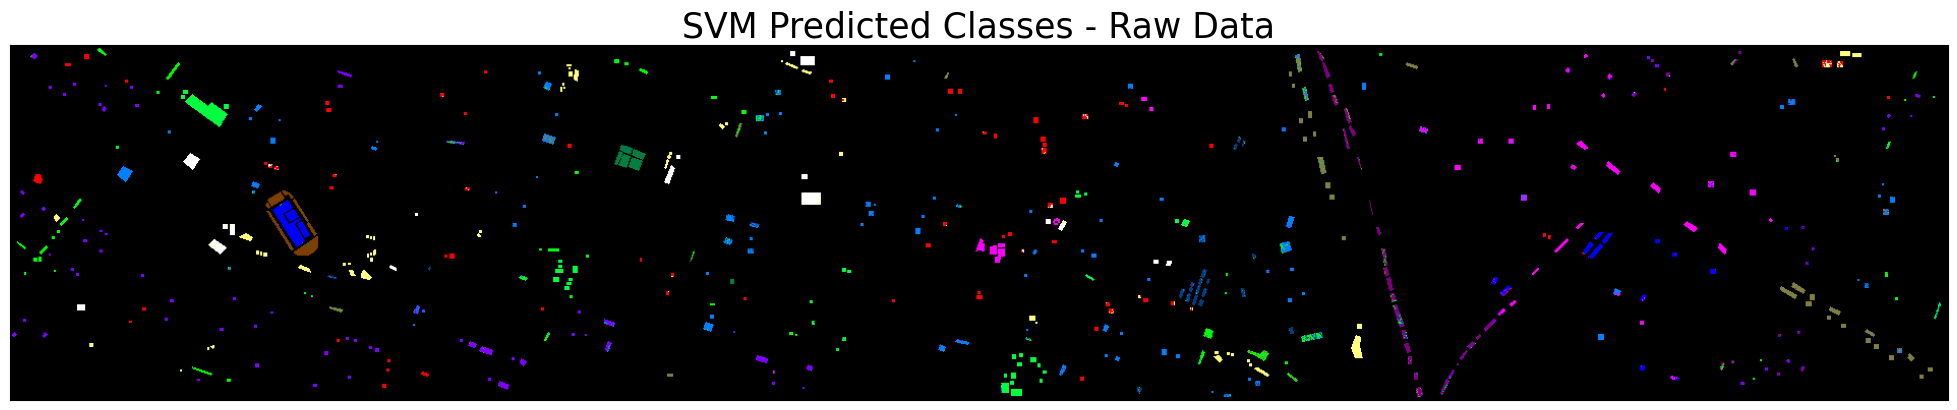

Best Model - accuracy: 83.33%, C: 2.5001, bias: 28


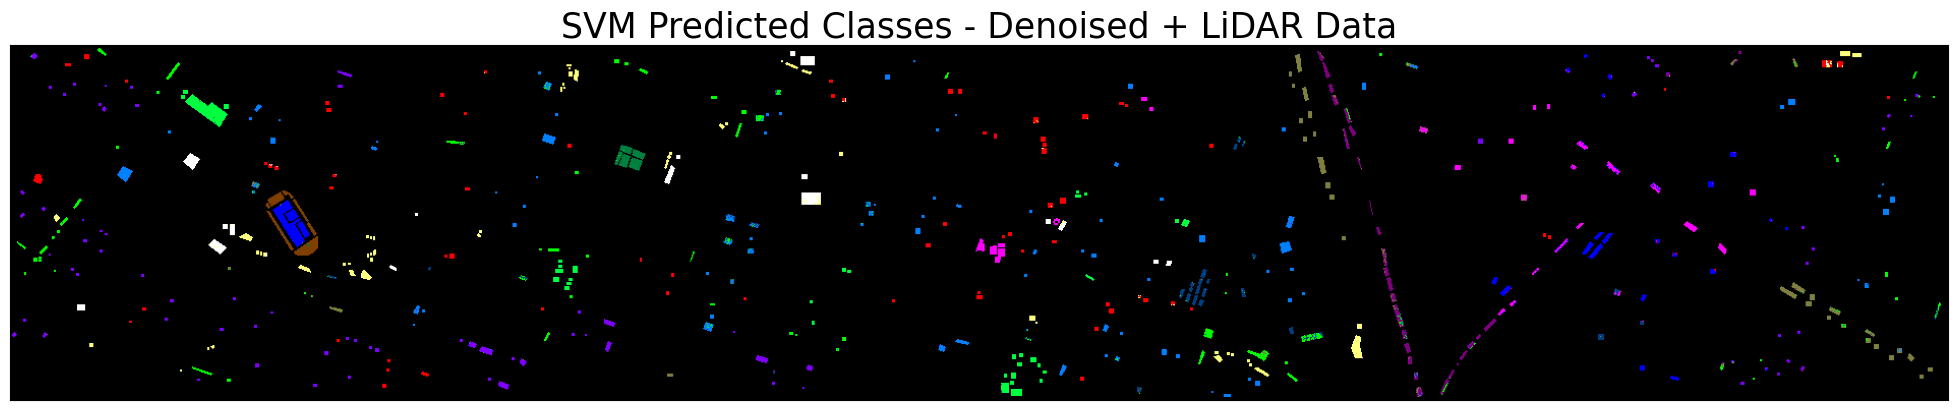

Best Model - accuracy: 83.57%, C: 2.5001, bias: 24


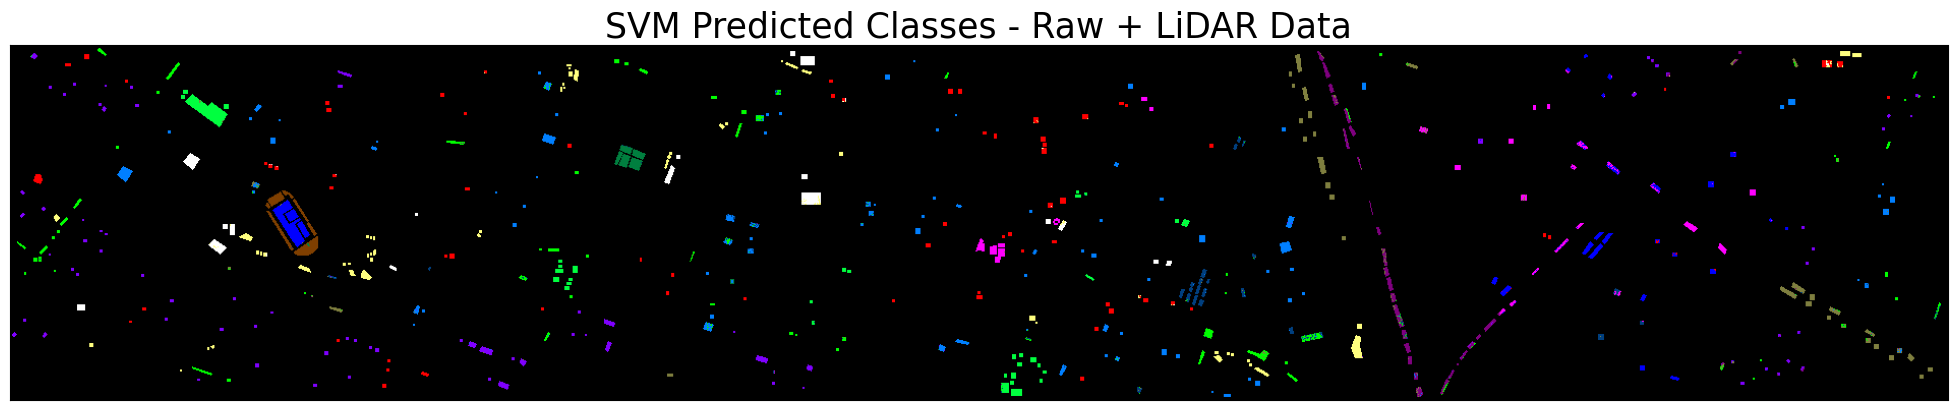

In [77]:
opt_biases = [24, 21, 28, 24]
i = 0
for key, value in dict_nn.items():
    X_train, y_train, X_test, y_test = train_test(value, labels_tr, labels_ts)
    X = np.concatenate((X_train, X_test), axis=0)
    y = np.concatenate((y_train, y_test), axis=0)
    
    _, _, _, _, y_pred_all = svm_model(X_train, y_train, X, y,
                                       [2.5001], kernel='poly', degree=3, bias=[opt_biases[i]], verbose=False)
    test_rgb = np.stack(np.zeros_like((lidar[0,:,:],)*3), axis=2)
    for row in range(labels_all.shape[0]):
        test_rgb[labels_all[row,0], labels_all[row, 1]] = avaris[int(y_pred_all[row])-1].tolist()
    plot_image(test_rgb, title=f'SVM Predicted Classes - {key} Data', fig_size=(25,7), save=False)
    i += 1


# Simple Neural Network
Cell commented out because it's very slow on cpu. Best model was produced using the below hyperparameters:

* penalties = np.logspace(-15, -4, 40)

* steps = [0.001]

Best models saved in 'best models/saved models' and loaded at the top.

In [ ]:
# dictionary to iterate over the different datasets
dict_nn = {'l': L, # Low rank (denoised) data
           'r': casi_unfold, # Raw data
           'lwl': L_w_lidar, # Low rank concatenated with Lidar
           'rwl': casi_w_lidar # raw concatenated with Lidar
          }

'''np.random.seed(0)
for key, value in dict_nn.items():
    X_train, y_train, X_test, y_test = train_test(value, labels_tr, labels_ts)

    #penalties = np.logspace(-10, -4, 7)
    penalties = np.logspace(-15, -4, 40)
    steps = [0.001]
    print(f'\n\n###########\nModel_{key}\n###########')
    opt_params = simple_nn(X_train, y_train,
                           X_test, y_test,
                           tol=1e-2,
                           steps=steps,
                           batch_size=64,
                           penalties=penalties,
                           max_iter=100,
                           verbose=3,
                           disp_cm=False,
                           model_name=f'NN_{key}',
                           seed=42)'''